In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rcParams.update({
    "figure.dpi": 600,
    "figure.figsize": (6, 2.5),
    "font.size": 8,
    "mathtext.fontset": "stix"
})

In [2]:
# Load simulation data
base_dir = '/Users/susannedahle/CellTypeDependenceElStim/white_noise_25_nov'

file_paths = [
    os.path.join(base_dir,f"cdm_data_neocortical_{i}.npy") 
    for i in range(8)
]

cdm_data_list = [
    np.load(path, allow_pickle=True).item()
    for path in file_paths
]

cdm_data = {}
for data in cdm_data_list:
    cdm_data.update(data)

In [3]:
t_vals_cdm = {}

for cell_name, data in cdm_data.items():

    frequencies = data['frequency']
    input_phases = data['input_current_phase']
    cdm_amps = data['cdm']
    cdm_phases = data['cdm_phase']
    cdm_amps_up = data['cdm_pos']
    cdm_phases_up = data['cdm_phase_pos']
    cdm_ams_down = data['cdm_neg']
    cdm_phases_down = data['cdm_phase_neg']

    cdm_up_vals = []
    cdm_down_vals = []

    for f_idx, f in enumerate(frequencies):
        input_phase = input_phases[f_idx]
        t_max_inp = (3*np.pi/2 - input_phase)/(2*np.pi*f)

        cdm_amp = cdm_amps[f_idx]
        cdm_phase = cdm_phases[f_idx]
        cdm_value = cdm_amp * np.sin(2*np.pi*f*t_max_inp + cdm_phase)
        
        if f_idx == 0:
            if cdm_value < 0:
                t_max_cdm_sign = 3
            else:
                t_max_cdm_sign = 1

        t_max_cdm = (t_max_cdm_sign * np.pi/2 - cdm_phase)/(2*np.pi*f)

        cdm_up_amp = cdm_amps_up[f_idx]
        cdm_up_phase = cdm_phases_up[f_idx]
        cdm_up_value = cdm_up_amp * np.sin(2*np.pi*f*t_max_cdm + cdm_up_phase)
        cdm_up_vals.append(cdm_up_value)

        cdm_down_amp = cdm_ams_down[f_idx]
        cdm_down_phase = cdm_phases_down[f_idx]
        cdm_down_value = cdm_down_amp * np.sin(2*np.pi*f*t_max_cdm + cdm_down_phase)
        cdm_down_vals.append(cdm_down_value)
    
    t_vals_cdm[cell_name] = {
        'frequency': frequencies,
        'cdm_up_vals': cdm_up_vals,
        'cdm_down_vals': cdm_down_vals
        }

In [4]:
def calculate_neuron_type_cdm_stats(t_vals_cdm):
    """Categorizes cells based on their names and calculates the average and standard deviation 
    of cdm_up and cdm_dowm for each frequency within each category.
    Ensures that Spiny Stellate cells are always index 0 in the result list.
    """

    avg_cdm_data_celltype = []
    categorized_data = {}

    # --- Organize data by category ---
    for cell_name, data in t_vals_cdm.items():
        # Determine the category of the cell
        if 'PC' in cell_name or 'SP' in cell_name:
            cell_category = 'Pyramidal cells'
        elif 'SS' in cell_name:
            cell_category = 'Spiny Stellate cells'
        else: 
            cell_category = 'Inhibitory neurons'

        if cell_category not in categorized_data:
            categorized_data[cell_category] = {}

        # Convert to numpy arrays
        cdm_up = np.nan_to_num(np.array(data['cdm_up_vals']), nan=0.0) # Set value to 0 if pz = NaN
        cdm_dowm = np.nan_to_num(np.array(data['cdm_down_vals']), nan=0.0)

        # Distribute values into frequency buckets
        for freq, up_val, down_val in zip(data['frequency'], cdm_up, cdm_dowm):
            if freq not in categorized_data[cell_category]:
                categorized_data[cell_category][freq] = {'cdm_up': [], 'cdm_dowm': []}
            
            categorized_data[cell_category][freq]['cdm_up'].append(up_val)
            categorized_data[cell_category][freq]['cdm_dowm'].append(down_val)

    # --- Define fixed category order ---
    category_order = ['Spiny Stellate cells', 'Pyramidal cells', 'Inhibitory neurons']

    # --- Compute averages and standard deviations in fixed order ---
    for category in category_order:
        if category not in categorized_data:
            continue  # Skip if category has no data

        freq_data = categorized_data[category]
        category_result = {
            'cell_category': category,
            'frequencies': [],
            'avg_cdm_up': [],
            'std_cdm_up': [],
            'avg_cdm_dowm': [],
            'std_cdm_dowm': [],
        }

        for freq, values in sorted(freq_data.items()):
            category_result['frequencies'].append(freq)
            category_result['avg_cdm_up'].append(np.nanmean(values['cdm_up']))
            category_result['std_cdm_up'].append(np.nanstd(values['cdm_up']))
            category_result['avg_cdm_dowm'].append(np.nanmean(values['cdm_dowm']))
            category_result['std_cdm_dowm'].append(np.nanstd(values['cdm_dowm']))

        avg_cdm_data_celltype.append(category_result)
    
    return avg_cdm_data_celltype


In [5]:
def print_avg_cdm_at_frequency(avg_cdm_data_celltype, target_freq):
    """Prints avg cdm_up and cdm_dowm at the closest frequency to target_freq for each cell type."""
    for cell_data in avg_cdm_data_celltype:
        cell_category = cell_data['cell_category']
        frequencies = np.array(cell_data['frequencies'])
        avg_cdm_up = np.array(cell_data['avg_cdm_up'])
        avg_cdm_dowm = np.array(cell_data['avg_cdm_dowm'])

        # Find closest frequency index
        idx = (np.abs(frequencies - target_freq)).argmin()
        closest_freq = frequencies[idx]

        print(f"Cell type: {cell_category}")
        print(f"  Closest frequency: {closest_freq} Hz")
        print(f"  Avg cdm_up: {avg_cdm_up[idx]:.3f} µm")
        print(f"  Avg cdm_dowm: {avg_cdm_dowm[idx]:.3f} µm")
        print("-" * 40)

In [6]:
def mark_subplots(axes, letters='ABCDEFGHIJKLMNOPQRSTUVWXYZ', xpos=-0.12, ypos=1.15, fontsize = 10):

    if not type(axes) is list:
        axes = [axes]

    for idx, ax in enumerate(axes):
        ax.text(xpos, ypos, letters[idx].capitalize(),
                horizontalalignment='center',
                verticalalignment='center',
                fontweight='demibold',
                fontsize=fontsize,
                transform=ax.transAxes)

In [13]:
def plot_combined_avg_and_celltype(data_dict, avg_cdm_data_celltype):
    """
    Creates a figure with two subplots:
    1) Per-cell traces of average return positions (above/below soma).
    2) Cell-type averages of cdm_up and cdm_dowm with std shading.
    """

    # --- Setup figure with two subplots ---
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))  # wider for side-by-side
    ax1, ax2 = axes

    max_cdm_above_all = 0
    max_cdm_below_all = 0
    max_avg_cdm_up = 0
    max_avg_cdm_dowm = 0

    # ========== LEFT PLOT: per-cell traces ==========
    for i, cell_name in enumerate(data_dict.keys()):
        cell_info = data_dict[cell_name]
        if 'PC' in cell_name or 'SP' in cell_name:
            colors = 'tab:green'
            labels = 'PC cell'
            alphas = 0.6
            linewidth = 1
        elif 'SS' in cell_name:
            colors = 'tab:purple'
            labels = 'SS cell'
            alphas = 1
            linewidth = 1.5
        else: 
            colors = 'tab:orange'
            labels = 'Inhb cell'
            alphas = 0.15
            linewidth = 1
        
        frequency = cell_info['frequency']
        cmd_above = cell_info['cdm_up_vals']
        cdm_below = cell_info['cdm_down_vals']

        if np.max(cmd_above[:-1]) > max_cdm_above_all:
            max_cdm_above_all = np.max(cmd_above[:-1])
        if np.max(np.abs(cdm_below[:-1])) > max_cdm_below_all:
            max_cdm_below_all = np.max(np.abs(cdm_below[:-1]))
        
        if len(frequency) != len(cmd_above) or len(frequency) != len(cdm_below):
            print(f"Warning: Skipping {cell_name} due to mismatched data cdms.")
            continue

        ax1.semilogx(frequency[:-1], cmd_above[:-1], 
                     label=f'{labels} (Above Soma)', 
                     color=colors, linestyle='-', 
                     alpha=alphas, linewidth=linewidth)
        
        ax1.semilogx(frequency[:-1], cdm_below[:-1], 
                     label=f'{labels} (Below Soma)', 
                     color=colors, linestyle='--', 
                     alpha=alphas, linewidth=linewidth)
    
    ax1.set_xlabel('Frequency [Hz]')
    ax1.set_ylabel('$p_z$ [nA$\cdot$µm]', fontsize = 9)
    ax1.set_title('Individual neocortical neurons', fontsize = 10)

    ax1.set_xlim(left=1, right=2000)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
    ax1.grid(which='major', linestyle='-', linewidth=0.7, alpha=0.8)
    ax1.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.8)

    # ========== RIGHT PLOT: cell-type averages ==========
    for cell_data in avg_cdm_data_celltype:
        cell_category = cell_data['cell_category']
        frequencies = np.array(cell_data['frequencies'])
        avg_cdm_up = np.array(cell_data['avg_cdm_up'])
        std_cdm_up = np.array(cell_data['std_cdm_up'])
        avg_cdm_dowm = np.array(cell_data['avg_cdm_dowm'])
        std_cdm_dowm = np.array(cell_data['std_cdm_dowm'])

        if np.max((avg_cdm_up + std_cdm_up)[:-1]) > max_avg_cdm_up:
            max_avg_cdm_up = np.max((avg_cdm_up + std_cdm_up)[:-1]) 
        if np.max(np.abs((avg_cdm_dowm + std_cdm_dowm)[:-1])) > max_avg_cdm_dowm:
            max_avg_cdm_dowm = np.max(np.abs((avg_cdm_dowm + std_cdm_dowm)[:-1]))

        if cell_category == 'Pyramidal cells':
            color = 'tab:green'
        elif cell_category == 'Spiny Stellate cells':
            color = 'tab:purple'
        else:
            color = 'tab:orange'

        ax2.semilogx(frequencies[:-1], avg_cdm_up[:-1], linestyle='-', 
                     label=f'{cell_category} (Above Soma)', color=color)
        ax2.fill_between(frequencies[:-1],
                         (avg_cdm_up - std_cdm_up)[:-1], (avg_cdm_up + std_cdm_up)[:-1],
                         color=color, alpha=0.2)

        ax2.semilogx(frequencies[:-1], avg_cdm_dowm[:-1], linestyle='--', 
                     label=f'{cell_category} (Below Soma)', color=color)
        ax2.fill_between(frequencies[:-1],
                         (avg_cdm_dowm - std_cdm_dowm)[:-1], (avg_cdm_dowm + std_cdm_dowm)[:-1],
                         color=color, alpha=0.2)

    ax2.set_xlabel('Frequency [Hz]')
    ax2.set_title('Cell-type averages', fontsize = 10)
    ax2.set_xlim(left=frequencies[0], right=2000)

    ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
    ax2.grid(which='major', linestyle='-', linewidth=0.7, alpha=0.8)
    ax2.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.8)

    max_y_all = max(max_cdm_above_all, max_cdm_below_all)
    y_marg_all = 0.05 * max_y_all
    ylim_all = max_y_all + y_marg_all
    max_y_avg = max(max_avg_cdm_up, max_avg_cdm_dowm)
    y_marg_avg = 0.05 * max_y_avg
    ylim_avg = max_y_avg + y_marg_avg

    ax1.set_ylim(0-ylim_all, 0+ylim_all)
    ax2.set_ylim(0-ylim_avg, 0+ylim_avg)

    handles, labels = ax2.get_legend_handles_labels()
    fig.legend(handles, labels, ncol=3, frameon=False, loc='center', bbox_to_anchor=(0.5, -0.05))

    # --- Final layout ---
    mark_subplots(fig.axes, ypos=1.1, fontsize = 12)
    plt.tight_layout()
    plt.savefig('/Users/susannedahle/Documents/Master/Code/fig_pdfs/fig8.pdf', bbox_inches='tight')
    plt.show()


<>:60: SyntaxWarning: invalid escape sequence '\c'
<>:60: SyntaxWarning: invalid escape sequence '\c'
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_44428/4203866249.py:60: SyntaxWarning: invalid escape sequence '\c'
  ax1.set_ylabel('$p_z$ [nA$\cdot$µm]', fontsize = 9)


In [14]:
avg_cdm_data_celltype = calculate_neuron_type_cdm_stats(t_vals_cdm)

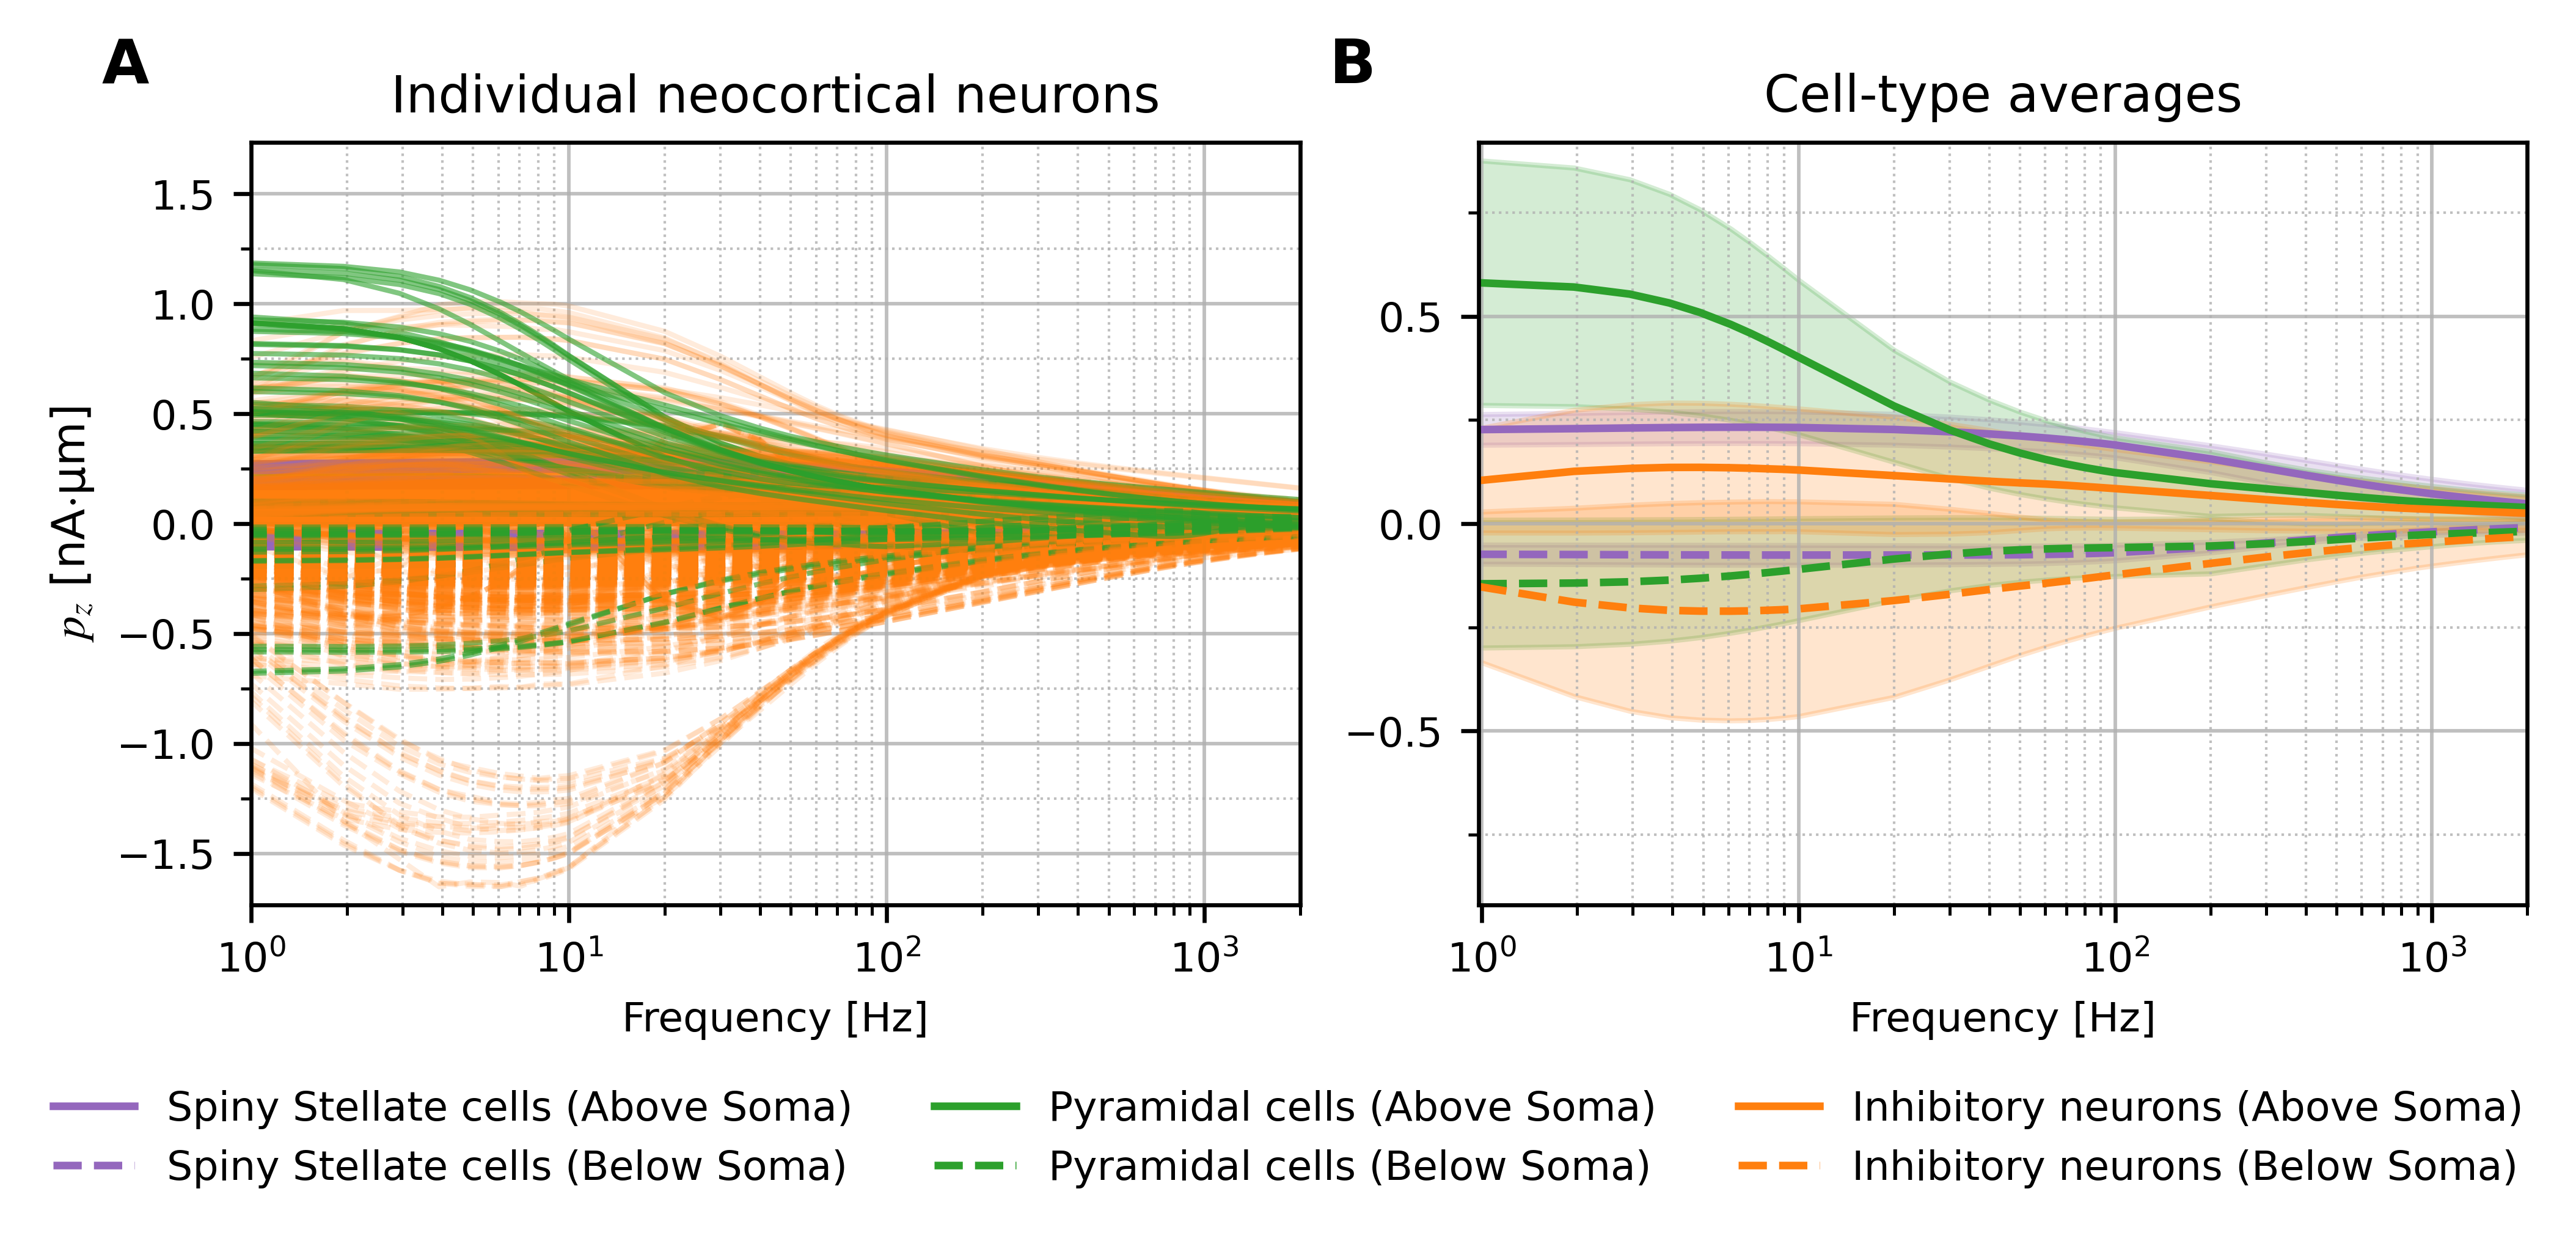

In [15]:
plot_combined_avg_and_celltype(t_vals_cdm, avg_cdm_data_celltype)